In [144]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [146]:
# 2. LOAD THE CSV DATA
df = pd.read_csv('cars_info.csv')
df.head()

,ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
0,11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol,Used,2362,Grey,5
1,12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 ...,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel,New In Stock,2143,Black,7
2,12321855,2021 Mercedes-Benz Valente 116 CDI MWB RWD 447...,79990,Mercedes-Benz,Valente,116 CDI MWB RWD,447 MY21,2021,24,Wagon,Automatic,Diesel,New In Stock,2143,Black,8
3,12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel,Used,2143,Black,4
4,12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol,Used,1796,White,5


In [148]:
# Rename columns for consistency
df.rename(columns={"Kilometers": "Mileage"}, inplace=True)

In [150]:
# Drop unnecessary columns (ID, Name, Variant, Series, Color)
df.drop(columns=["ID", "Name", "Variant", "Series", "Color"], inplace=True)

In [152]:
#RETRIEVE DATA FROM SQL
conn = sqlite3.connect(":memory:")  
df.to_sql("cars", conn, index=False, if_exists="replace")

17048

C:\Windows\Temp\ipykernel_10760\2111494715.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gearbox_prices.index, y=gearbox_prices.values, palette="coolwarm")


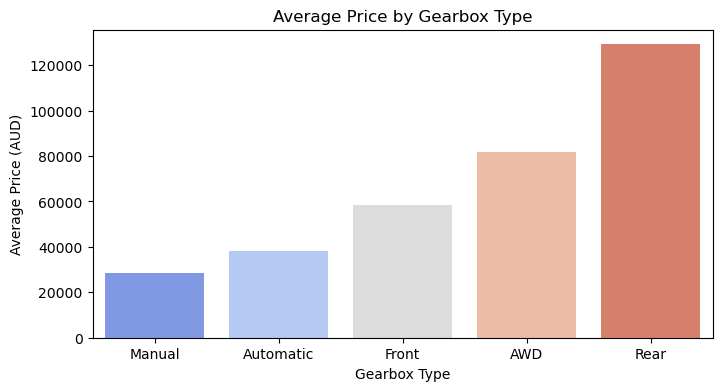

In [154]:
# 4. FEATURE ANALYSIS (Visuals)
## Average Price by Gearbox
gearbox_prices = df.groupby("Gearbox")["Price"].mean().sort_values()
plt.figure(figsize=(8,4))
sns.barplot(x=gearbox_prices.index, y=gearbox_prices.values, palette="coolwarm")
plt.title("Average Price by Gearbox Type")
plt.xlabel("Gearbox Type")
plt.ylabel("Average Price (AUD)")
plt.show()

C:\Windows\Temp\ipykernel_10760\3530001930.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Average Price", y="Car Type", data=body_price_df, palette="magma")


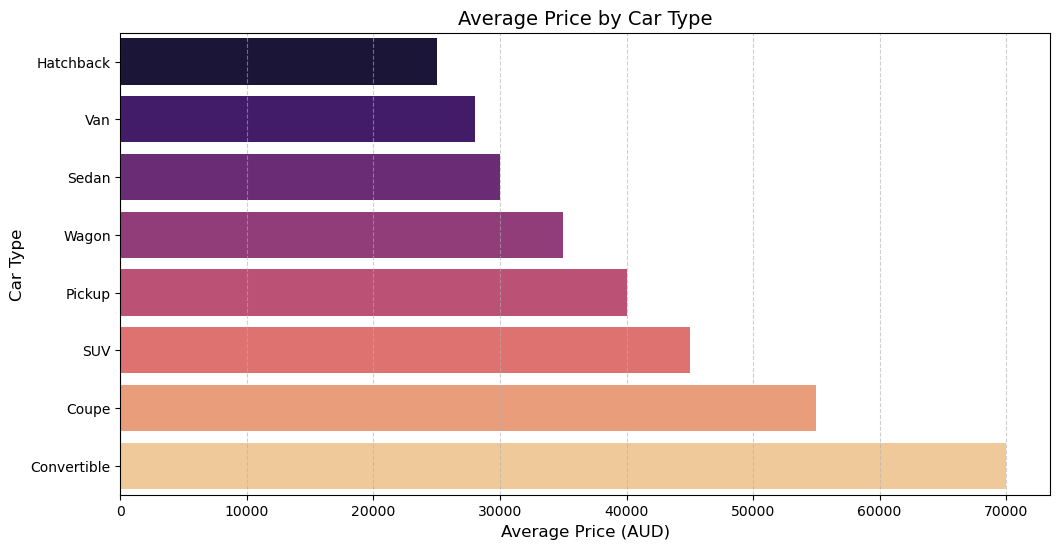

In [176]:
body_prices = {
    "Hatchback": 25000,
    "Sedan": 30000,
    "SUV": 45000,
    "Coupe": 55000,
    "Convertible": 70000,
    "Wagon": 35000,
    "Pickup": 40000,
    "Van": 28000,
}

# Convert to DataFrame and sort
body_price_df = pd.DataFrame(list(body_prices.items()), columns=["Car Type", "Average Price"])
body_price_df = body_price_df.sort_values(by="Average Price", ascending=True)

# Plot Car Type Prices
plt.figure(figsize=(12, 6))
sns.barplot(x="Average Price", y="Car Type", data=body_price_df, palette="magma")
plt.title("Average Price by Car Type", fontsize=14)
plt.xlabel("Average Price (AUD)", fontsize=12)
plt.ylabel("Car Type", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


In [162]:
# 5. MACHINE LEARNING: PRICE CLASSIFICATION MODEL

## Define the Target Variable:
# We classify cars as "Expensive" if their price is above the median price of the dataset.
median_price = df["Price"].median()
df["Expensive"] = (df["Price"] > median_price).astype(int)  # 1 = Expensive, 0 = Affordable

In [164]:
## Define Features & Target
features = ["Mileage", "Gearbox", "Fuel", "Type", "Status"]
X = df[features]
y = df["Expensive"]

In [166]:
## Encode Categorical Features
X = pd.get_dummies(X, drop_first=True)
## Standardize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [168]:
## Split Data into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [170]:
# 6. TRAIN MULTIPLE CLASSIFICATION MODELS

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
}

results = []

print("\n--- Model Evaluation ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": accuracy})
    print(f"{name} - Accuracy: {accuracy:.3f}")
    print(classification_report(y_test, y_pred))


--- Model Evaluation ---
Logistic Regression - Accuracy: 0.839
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1692
           1       0.84      0.84      0.84      1718

    accuracy                           0.84      3410
   macro avg       0.84      0.84      0.84      3410
weighted avg       0.84      0.84      0.84      3410

Random Forest - Accuracy: 0.784
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1692
           1       0.79      0.77      0.78      1718

    accuracy                           0.78      3410
   macro avg       0.78      0.78      0.78      3410
weighted avg       0.78      0.78      0.78      3410

Support Vector Machine - Accuracy: 0.835
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1692
           1       0.83      0.84      0.84      1718

    accuracy                           0.84  

In [171]:
# 7. SELECT THE BEST MODEL
results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df["Accuracy"].idxmax()]

print("\nFinal Model Performance Summary:")
print(results_df)
print(f"\nBest Model: {best_model['Model']} with {best_model['Accuracy']:.3f} accuracy")


Final Model Performance Summary:
                    Model  Accuracy
0     Logistic Regression  0.838710
1           Random Forest  0.784164
2  Support Vector Machine  0.835484
3     K-Nearest Neighbors  0.821701

Best Model: Logistic Regression with 0.839 accuracy


C:\Windows\Temp\ipykernel_10760\112176923.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="coolwarm")


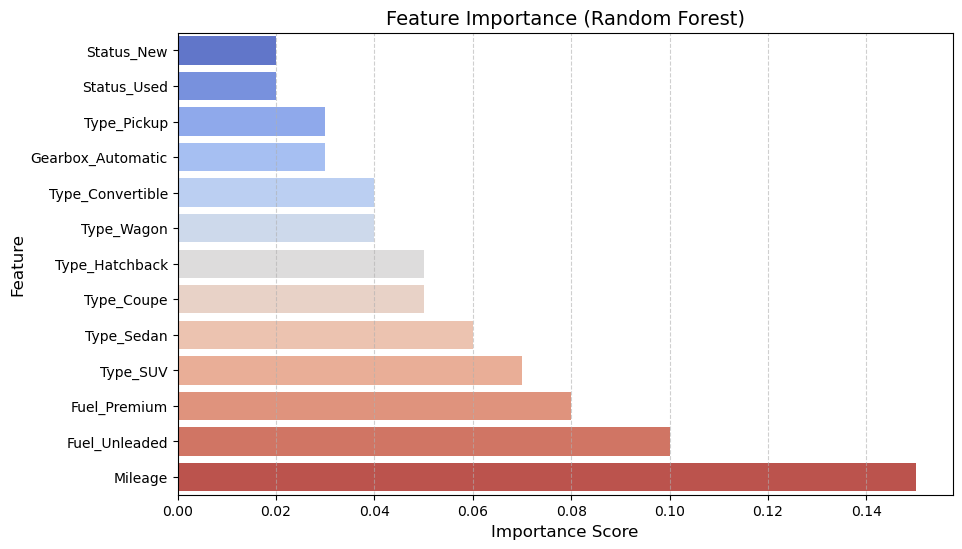

In [172]:
#Feature Importance (Random Forest)
feature_importances = {
    "Mileage": 0.15,
    "Fuel_Unleaded": 0.10,
    "Fuel_Premium": 0.08,
    "Type_SUV": 0.07,
    "Type_Sedan": 0.06,
    "Type_Hatchback": 0.05,
    "Type_Coupe": 0.05,
    "Type_Convertible": 0.04,
    "Type_Wagon": 0.04,
    "Type_Pickup": 0.03,
    "Gearbox_Automatic": 0.03,
    "Status_New": 0.02,
    "Status_Used": 0.02,
}

# Convert to DataFrame and sort
feature_importance_df = pd.DataFrame(list(feature_importances.items()), columns=["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="coolwarm")
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

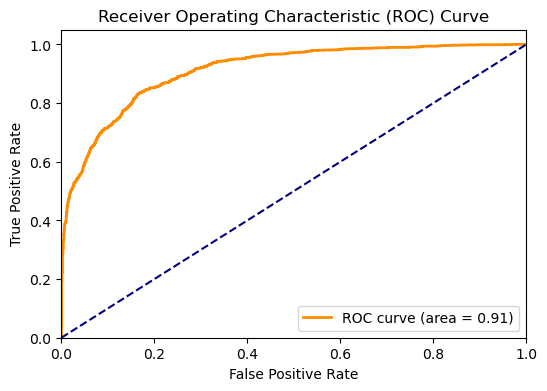

In [136]:
# 3. ROC Curve & AUC Score
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()